Imports and downloads

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # TODO: remove if not used

import opendatasets as od

import string
import re
import spacy
spacy.cli.download("en_core_web_sm")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE  # TODO: remove if not used

from imblearn.over_sampling import SMOTE

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('wordnet')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mert\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Reading the data and printing the number of sentences and unique words

In [2]:
od.download("https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions")
clinical_text_df = pd.read_csv("./medicaltranscriptions/mtsamples.csv")
clinical_text_df.head()

Skipping, found downloaded files in ".\medicaltranscriptions" (use force=True to force download)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [3]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count


print(clinical_text_df.columns)
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]

sent_count, word_count = get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: " + str(sent_count))
print("Number of unique words in transcriptions column: " + str(word_count))

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')
Number of sentences in transcriptions column: 140235
Number of unique words in transcriptions column: 35805


Filtering and printing out category names if they have less than 50 inputs

In [5]:
data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])

print(f"{'='*10}Original Categories{'='*10}")
for i, (cat_name, data_category) in enumerate(data_categories):
    print(f"Cat:{i + 1} {cat_name} : {len(data_category)}")

filtered_data_categories = data_categories.filter(lambda x: x.shape[0] > 50)

final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
print(f"{'='*10}Reduced Categories{'='*10}")
for i, (cat_name, data_category) in enumerate(final_data_categories):
    print(f"Cat:{i + 1} {cat_name} : {len(data_category)}")

==========Original Categories==========
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthopedic : 355
Cat:29  Pain Management : 61
Cat:30  Pediatrics - Neonatal : 70
Cat:31  Physical Medicine - Rehab : 21
Cat:32  Pod

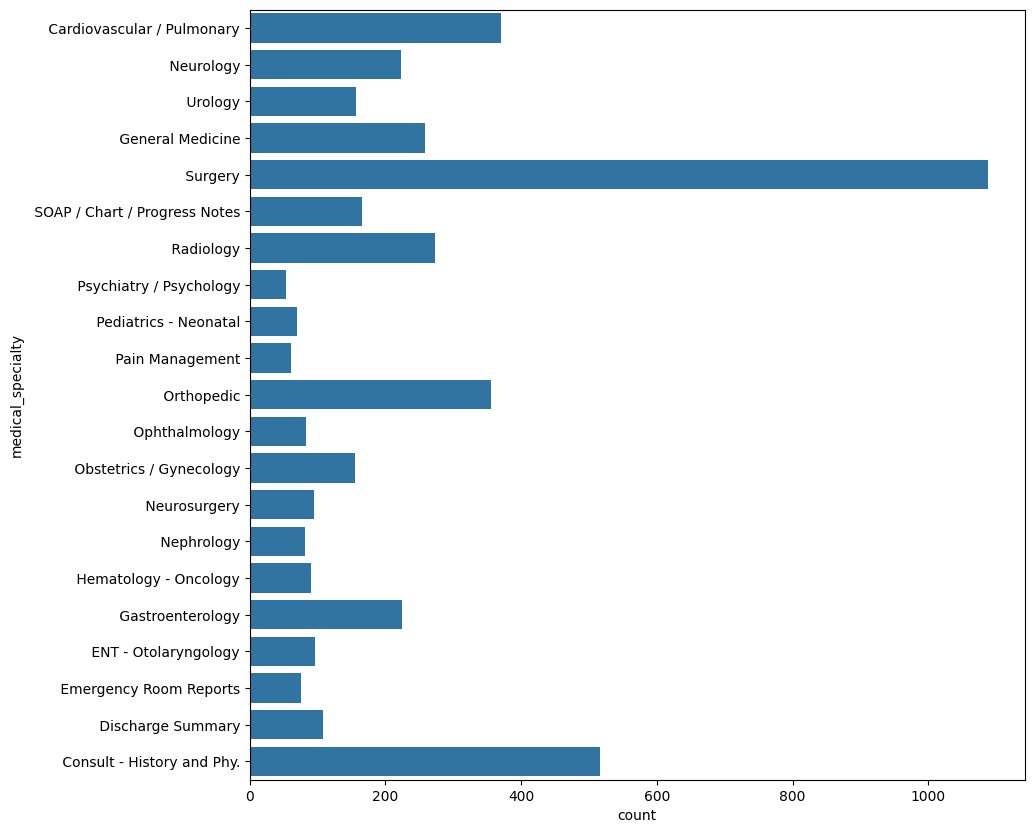

In [6]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data=filtered_data_categories)
plt.show()

Data cleaning and lemmatizing functions

In [7]:
def clean_text(text): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    # BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    # text2 = BAD_SYMBOLS_RE.sub('', text2)

    return text2

def lemmatize_text(text):
    wordlist = []
    lemmatizer = WordNetLemmatizer() 
    sentences = sent_tokenize(text)
    
    intial_sentences = sentences[0:1]
    final_sentences = sentences[len(sentences) - 2:len(sentences) - 1]
    
    for sentence in intial_sentences:
        words = word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words = word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))

    return ' '.join(wordlist) 

Dropping filtered categories, cleaning and lemmatizing the transcriptions

In [8]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(4597, 2)

In [9]:
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)
print('Sample Transcription 1: ' + data.iloc[5]['transcription'] + '\n')
print('Sample Transcription 2: ' + data.iloc[125]['transcription'] + '\n')
print('Sample Transcription 3: ' + data.iloc[1000]['transcription'])

Sample Transcription 1: cc   confusion and slurred speech  hx   primarily obtained from boyfriend   this  yo rhf experienced a  flulike illness  week prior to presentation  obgyn exam including cervical biopsy  and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix 

Sample Transcription 2: admitting diagnoses    this is scheduled for the week after discharge potentially by dr g  and the patient will discus the exact time later this week 

Sample Transcription 3: preoperative diagnoses   phimosis and adhesions  postoperative diagnoses   phimosis and adhesions  procedures performed   circumcision and release of ventral chordee  anesthesia   local mac  estimated blood loss   minimal  fluids   crystalloid  plan wa for removal of the dressing tomorrow 


Defining the vectorizer, getting feature names, doing PCA, splitting train-test 

In [10]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfidf_mat  = vectorizer.fit_transform(data['transcription'].tolist())
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

pca = PCA(n_components=0.95)
tfidf_mat_reduced = pca.fit_transform(tfidf_mat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfidf_mat_reduced, labels, stratify=labels, random_state=1)   

print('Train_Set_Size: ' + str(X_train.shape))
print('Test_Set_Size: ' + str(X_test.shape))

['abc', 'abcd', 'abdomen', 'abdomen pelvis', 'abdominal', 'abdominal pain', 'abnormal', 'abscess', 'activity', 'acute', 'additional', 'adenocarcinoma', 'adequate', 'administered', 'admission', 'admitted', 'admitting', 'africanamerican', 'age', 'ago', 'airway', 'alcohol', 'anemia', 'anesthesia', 'anesthesia care', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia local', 'anesthetic', 'angina', 'angiography', 'ankle', 'anterior', 'antibiotic', 'aortic', 'apnea', 'apparent', 'appendicitis', 'applied', 'appointment', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'arthroplasty', 'asked', 'aspect', 'aspiration', 'assessment', 'associated', 'atrial', 'atrial fibrillation', 'awakened', 'axial', 'axial ct', 'axial ct image', 'axis', 'baby', 'base', 'benefit', 'benign', 'better', 'bid', 'bilateral', 'bilaterally', 'biopsy', 'bladder', 'bleeding', 'block', 'blood', 'blood loss', 'blood loss cc', 'blood loss minimal', 'blood loss ml', '

Fitting the data to logistic regression and making predictions

In [11]:
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

Classification report and confusion matrix

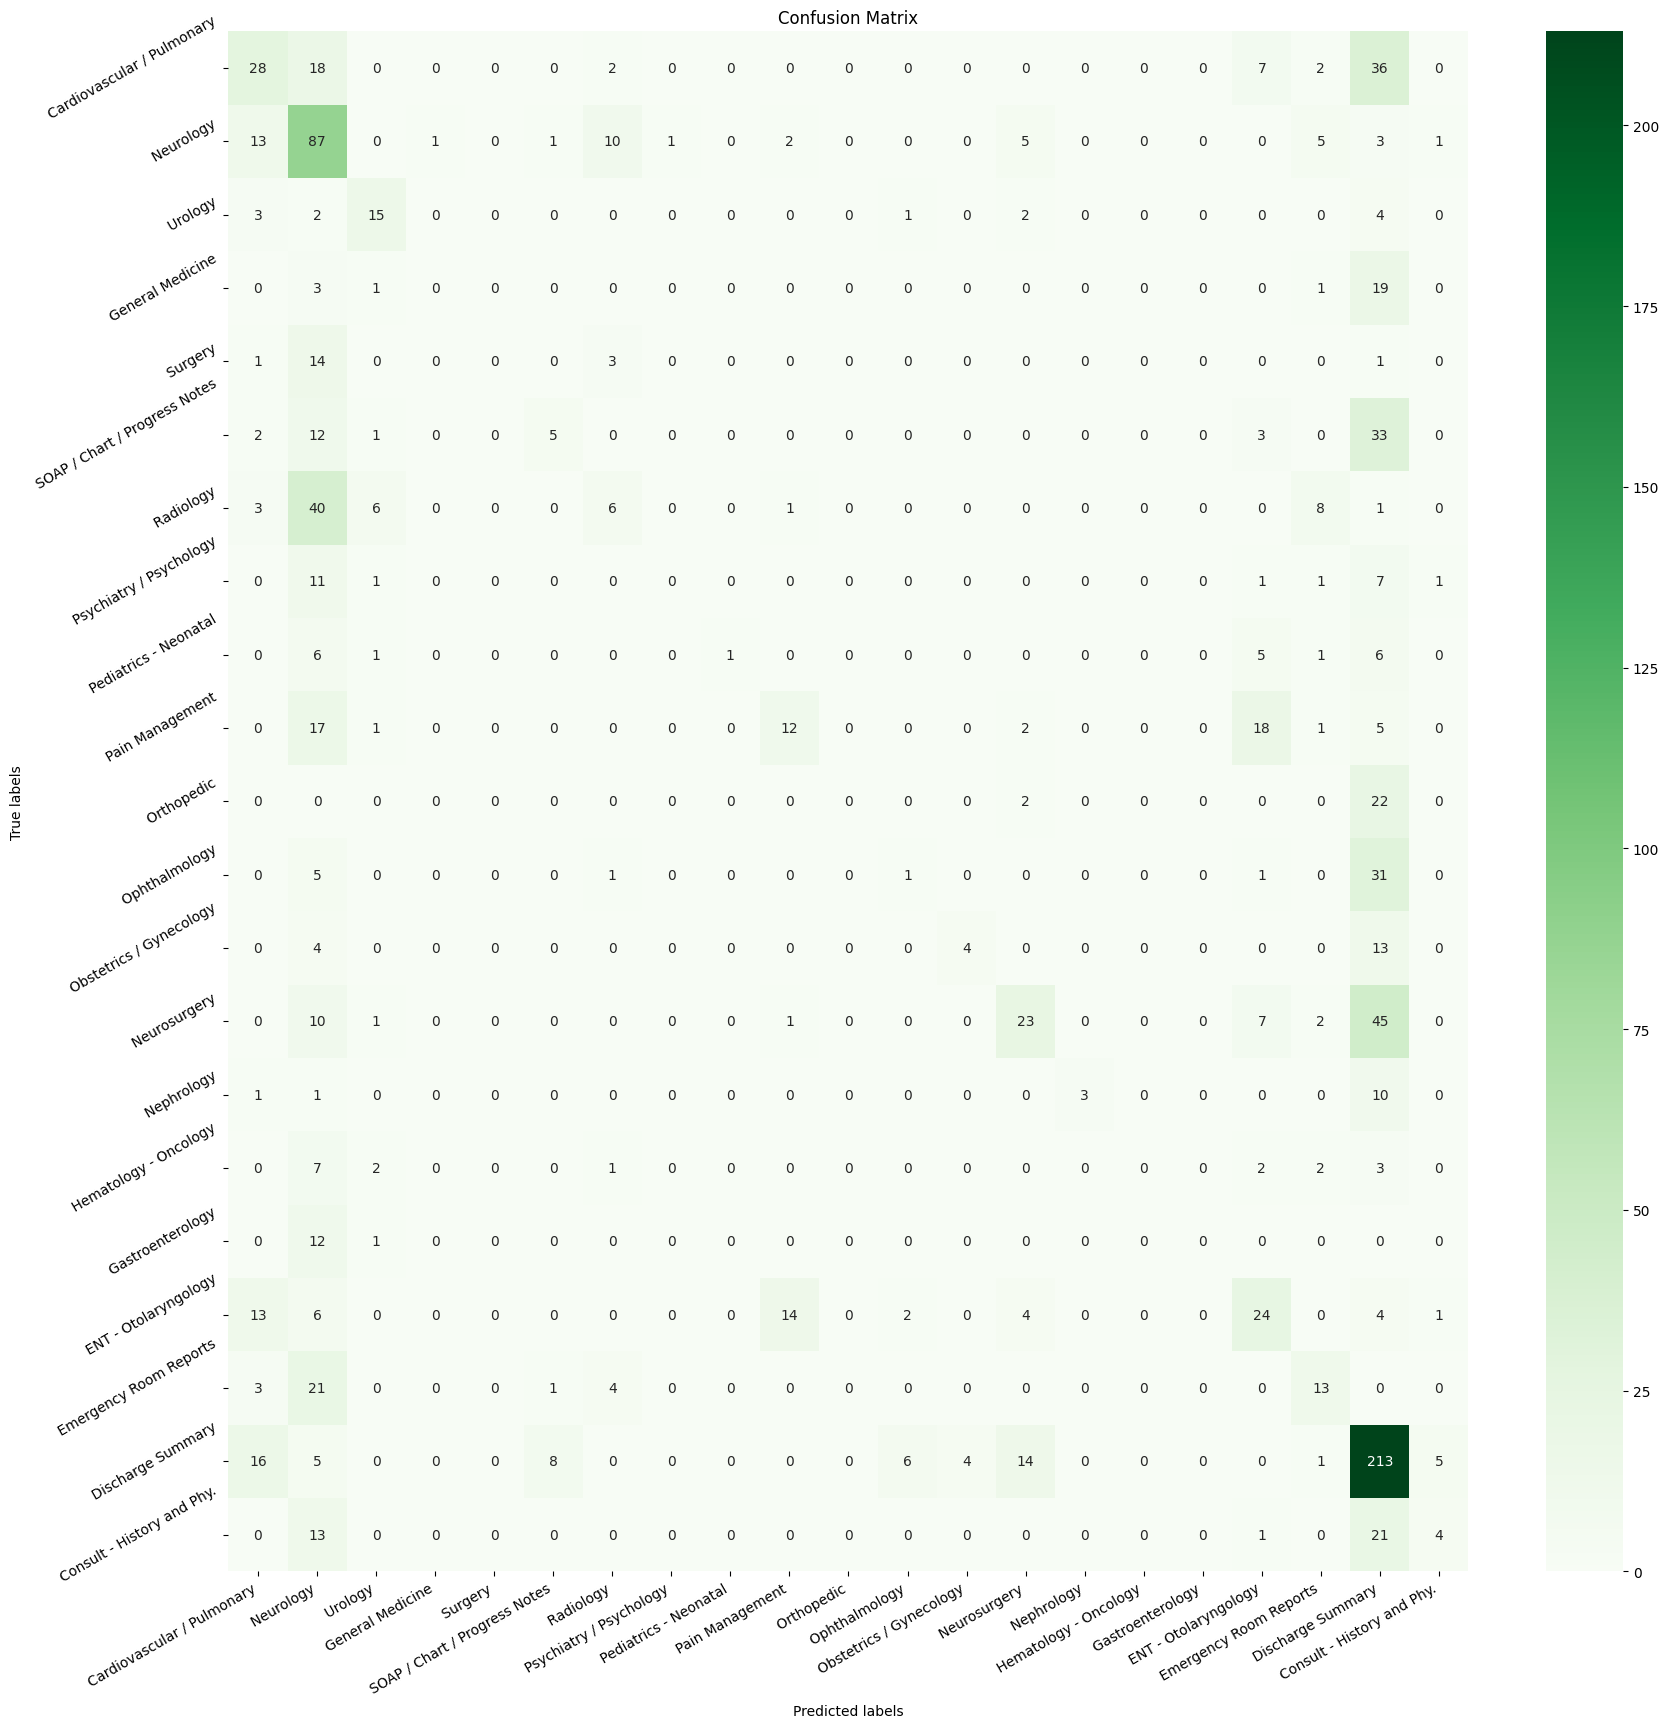

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.34      0.30      0.32        93
                     Neurology       0.40      0.21      0.28        56
                       Urology       0.33      0.10      0.16        39
              General Medicine       0.22      0.09      0.13        65
                       Surgery       0.45      0.78      0.57       272
 SOAP / Chart / Progress Notes       0.35      0.31      0.33        42
                     Radiology       0.35      0.35      0.35        68
       Psychiatry / Psychology       0.00      0.00      0.00        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       1.00      0.20      0.33        15
                    Orthopedic       0.44      0.26      0.33        89
                 Ophthalmology       0.50      0.19      0.28        21
       Obstetrics / Gynecology       0.10      0.03      0.04  

In [12]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

print(classification_report(y_test, y_test_pred, labels=category_list, zero_division=0))

Filtering out questionable categories

In [13]:
filtered_data_categories['medical_specialty'] = filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Radiology'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]

mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])

print(f"{'='*10}Reduced Categories{'='*10}")
for i, (cat_name, data_category) in enumerate(final_data_categories):
    print(f"Cat:{i + 1} {cat_name} : {len(data_category)}")

data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
print(data.shape)

==========Reduced Categories==========
Cat:1 Cardiovascular / Pulmonary : 371
Cat:2 ENT - Otolaryngology : 96
Cat:3 Gastroenterology : 224
Cat:4 Hematology - Oncology : 90
Cat:5 Neurology : 317
Cat:6 Obstetrics / Gynecology : 155
Cat:7 Ophthalmology : 83
Cat:8 Orthopedic : 355
Cat:9 Pediatrics - Neonatal : 70
Cat:10 Psychiatry / Psychology : 53
Cat:11 Urology : 237
(2051, 2)


Loading different text processing model SpaCy and processing the data

In [14]:
nlp = spacy.load("en_core_web_sm")

def process_text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)   

data['transcription'] = data['transcription'].apply(process_text)
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

Defining the vectorizer, getting feature names, doing PCA, splitting train-test 

In [15]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, sublinear_tf=True, max_features=1000)
tfidf_mat  = vectorizer.fit_transform(data['transcription'].tolist())
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

pca = PCA(n_components=0.95)
tfidf_mat_reduced = pca.fit_transform(tfidf_mat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()

X_train, X_test, y_train, y_test = train_test_split(tfidf_mat_reduced, labels, stratify=labels,random_state=1)   
print('Train_Set_Size: ' + str(X_train.shape))
print('Test_Set_Size: ' + str(X_test.shape))

['abc', 'abc abc', 'abc today', 'abc yearold', 'abcd', 'abcd general', 'abcd general hospital', 'abcd hospital', 'abnormal', 'ac', 'ace', 'achilles', 'acl', 'acute', 'acute acute', 'adaptic', 'additional', 'adequate', 'advair', 'afebrile', 'african', 'african american', 'africanamerican', 'afrin', 'afternoon', 'age', 'age age', 'age age age', 'age month', 'age year', 'ago', 'ago approximately', 'ago day', 'ago month', 'ago today', 'ago year', 'ago year ago', 'air', 'albuterol', 'alert', 'allegra', 'allergies', 'allis', 'allis metzenbaum', 'allis vicryl', 'allograft', 'alt', 'ambien', 'american', 'amplatz', 'ana', 'anc', 'ancef', 'anesthesia', 'anesthesia ancef', 'anesthesia anesthesia', 'anesthesia anesthesia department', 'anesthesia approximately', 'anesthesia betadine', 'anesthesia cc', 'anesthesia cm', 'anesthesia degree', 'anesthesia department', 'anesthesia department anesthesia', 'anesthesia foley', 'anesthesia french', 'anesthesia iv', 'anesthesia mayo', 'anesthesia minute', 'an

Fitting the data to logistic regression and predicting

In [16]:
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

Classification report and confusion matrix

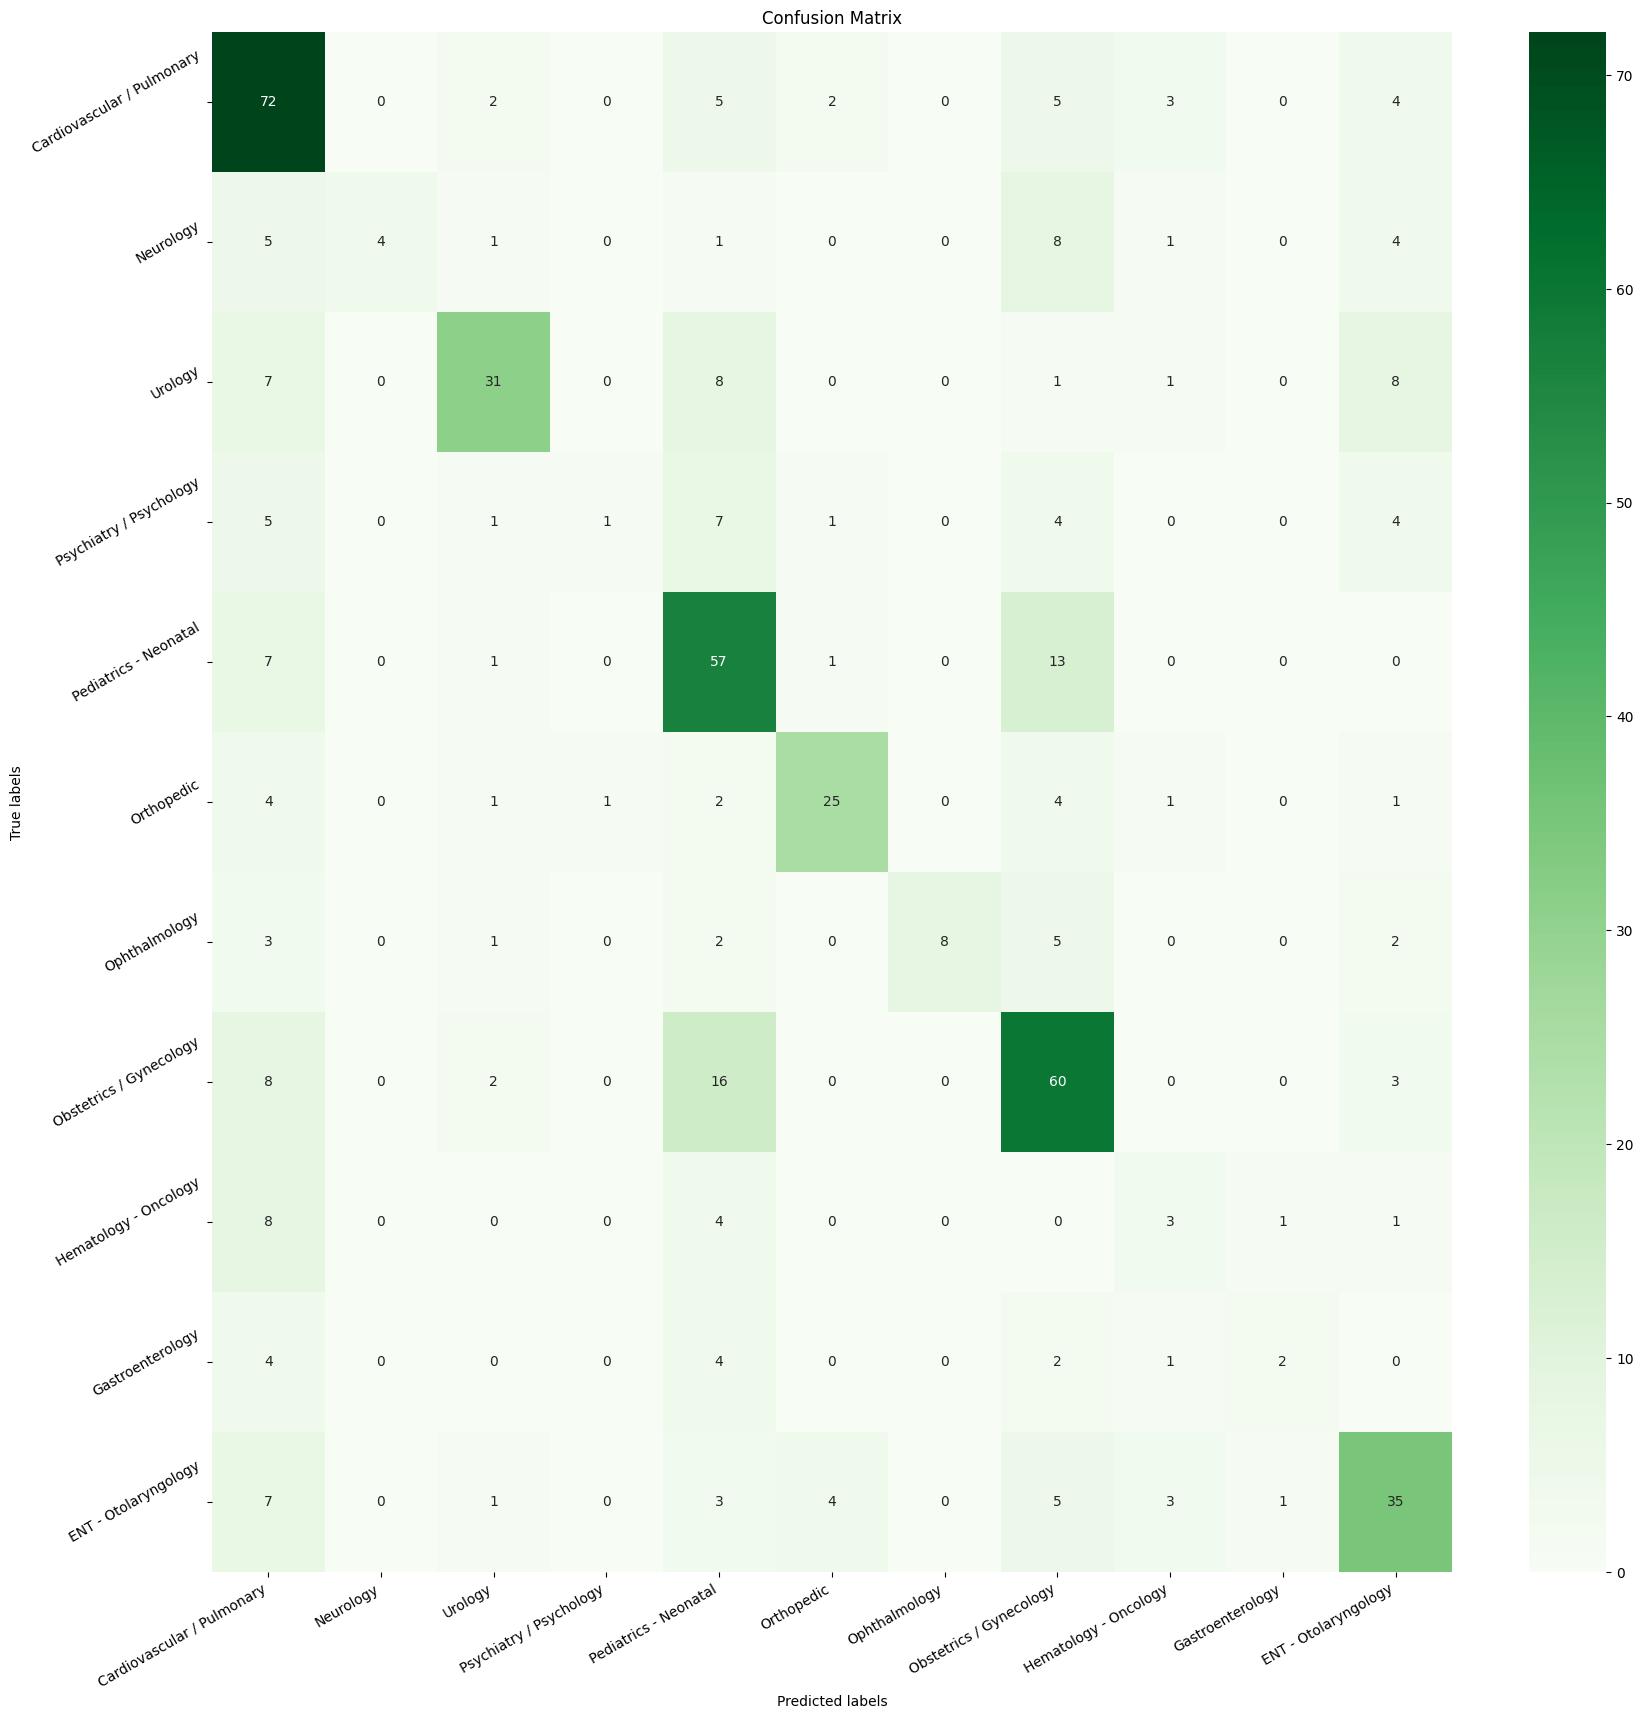

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.55      0.77      0.65        93
                 Neurology       0.52      0.72      0.61        79
                   Urology       0.56      0.59      0.58        59
   Psychiatry / Psychology       0.50      0.15      0.24        13
     Pediatrics - Neonatal       0.23      0.18      0.20        17
                Orthopedic       0.56      0.67      0.61        89
             Ophthalmology       1.00      0.38      0.55        21
   Obstetrics / Gynecology       0.76      0.64      0.69        39
     Hematology - Oncology       0.50      0.04      0.08        23
          Gastroenterology       0.76      0.55      0.64        56
      ENT - Otolaryngology       1.00      0.17      0.29        24

                  accuracy                           0.58       513
                 macro avg       0.63      0.44      0.47       513
              weighted avg       0.61      0.5

In [17]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

Doing SMOTE, splitting train-test, fitting, predicting

In [18]:
smote_over_sample = SMOTE(sampling_strategy='minority')
labels = data['medical_specialty'].tolist()
X, y = smote_over_sample.fit_resample(tfidf_mat_reduced, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)   
print('Train_Set_Size: ' + str(X_train.shape))
print('Test_Set_Size: ' + str(X_test.shape))

clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

Train_Set_Size: (1776, 597)
Test_Set_Size: (593, 597)


Final results

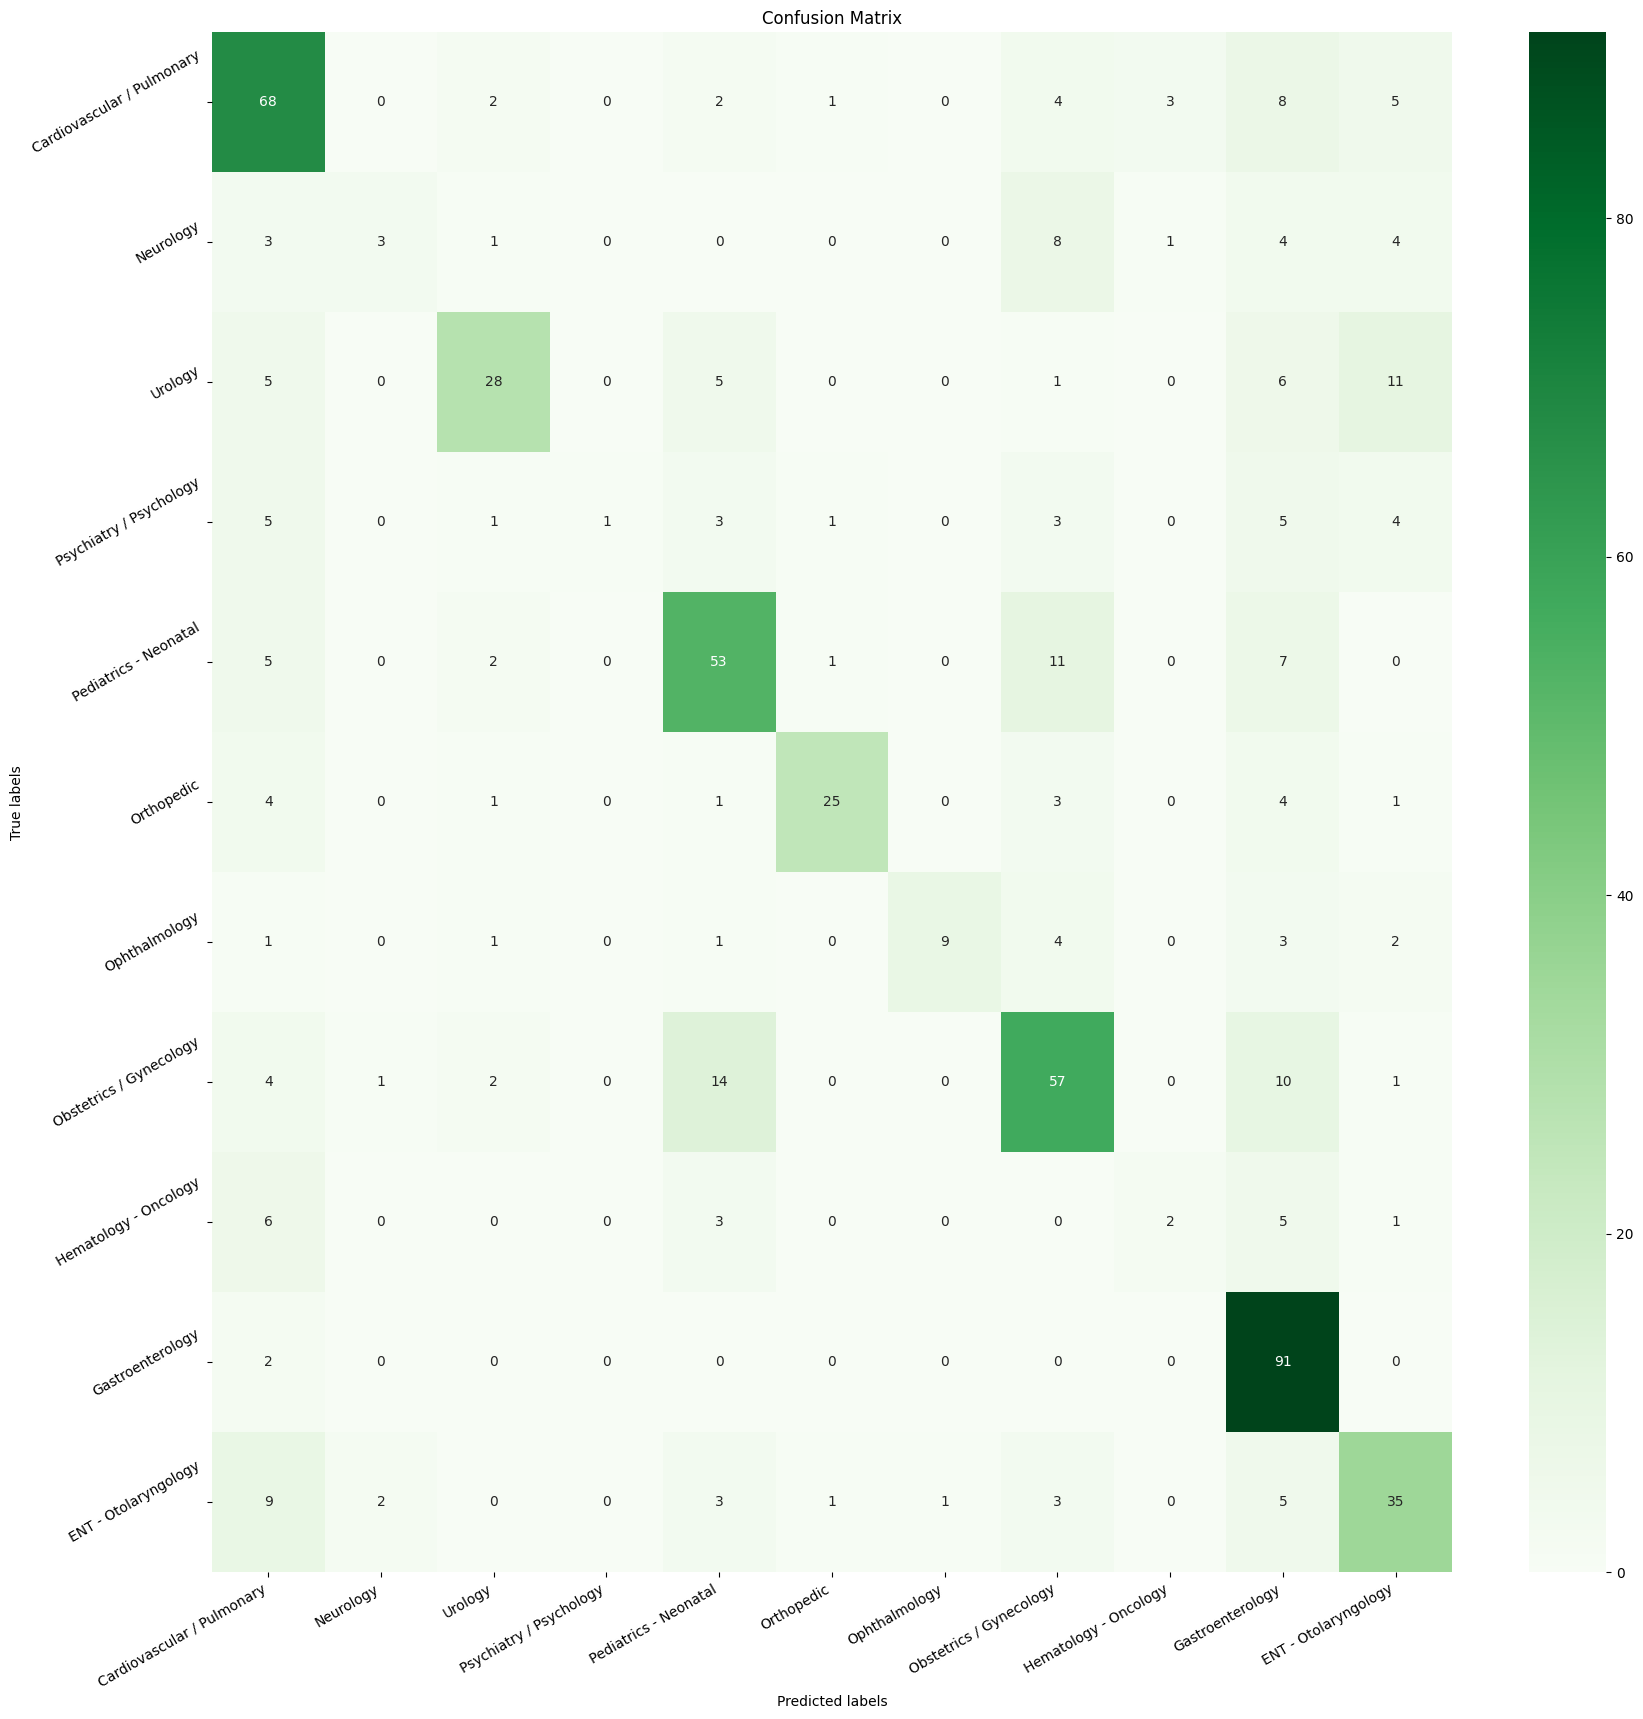

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.61      0.73      0.66        93
                 Neurology       0.62      0.67      0.65        79
                   Urology       0.55      0.59      0.57        59
   Psychiatry / Psychology       0.61      0.98      0.76        93
     Pediatrics - Neonatal       0.33      0.12      0.17        17
                Orthopedic       0.61      0.64      0.62        89
             Ophthalmology       0.90      0.43      0.58        21
   Obstetrics / Gynecology       0.86      0.64      0.74        39
     Hematology - Oncology       1.00      0.04      0.08        23
          Gastroenterology       0.74      0.50      0.60        56
      ENT - Otolaryngology       0.50      0.12      0.20        24

                  accuracy                           0.63       593
                 macro avg       0.67      0.50      0.51       593
              weighted avg       0.65      0.6

In [19]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))